<a href="https://colab.research.google.com/github/Anjaszz/Klasifikasi-Penyakit-Daun-Anggur/blob/main/Klasifikasi_penyakit_daun_anggur_2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Klasifikasi penyakit pada daun anggur menggunakan CNN(Convolutional Neural Network)**
**Created by Anjas rani**

https://anjasrani.my.id

# **Ekstraksi Dataset Anggur dari File ZIP**
Pada code dibawah ini, kita mengekstrak dataset anggur yang disimpan dalam file ZIP. Proses ini memungkinkan kita untuk mengakses gambar-gambar daun anggur yang akan digunakan untuk melatih model klasifikasi. Setelah diekstrak, kita juga akan memeriksa struktur direktori dari dataset yang diambil.


In [1]:
import zipfile, os
local_zip = '/tmp/grape-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/grape-data'
os.listdir(base_dir)


['BlackMeasles', 'HealthyGrapes', 'LeafBlight', 'BlackRot']

# **Mengatur Data dan Preprocessing untuk Klasifikasi Gambar Menggunakan CNN**
Kode ini mempersiapkan dataset gambar untuk pelatihan model Convolutional Neural Network (CNN). Menggunakan ImageDataGenerator, gambar dinormalisasi dan dibagi menjadi data pelatihan dan validasi. Metode flow_from_directory memuat gambar dari folder berdasarkan kelas, dengan ukuran gambar ditetapkan ke 150x150 piksel.

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

BATCH_SIZE = 32
IMG_HEIGHT = 150
IMG_WIDTH = 150
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

# Buat dataset pelatihan
train_dataset = image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

# Buat dataset validasi
validation_dataset = image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

# Terapkan caching, pengacakan, dan prefetching pada dataset pelatihan
train_dataset_final = (
    train_dataset
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

# Terapkan caching dan prefetching pada dataset validasi
validation_dataset_final = (
    validation_dataset
    .cache()
    .prefetch(PREFETCH_BUFFER_SIZE)
)

# Sekarang train_dataset_final dan validation_dataset_final siap digunakan untuk melatih model


Found 1600 files belonging to 4 classes.
Using 1280 files for training.
Found 1600 files belonging to 4 classes.
Using 320 files for validation.


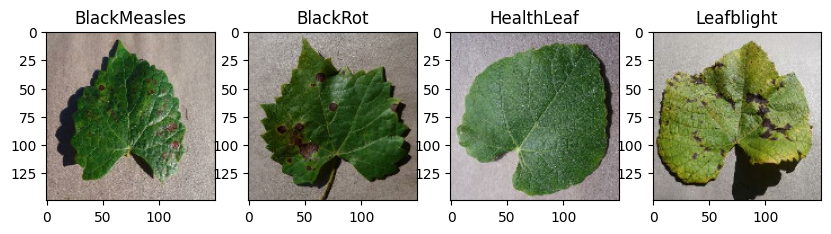

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Mengambil contoh gambar dari batch pertama dalam train_dataset
class_names = ['BlackMeasles', 'BlackRot', 'HealthLeaf', 'Leafblight']
num_classes = len(class_names)
example_images = {class_name: None for class_name in class_names}

# Iterasi batch untuk mengambil satu contoh dari setiap kelas
for images, labels in train_dataset.take(1):  # hanya satu batch
    for i in range(len(images)):
        class_index = np.argmax(labels[i])  # Mendapatkan index kelas
        class_name = class_names[class_index]

        if example_images[class_name] is None:  # Hanya mengambil satu contoh per kelas
            example_images[class_name] = images[i]

# Menampilkan contoh gambar
plt.figure(figsize=(10, 10))
for i, (class_name, img) in enumerate(example_images.items()):
    plt.subplot(1, num_classes, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("on")
plt.show()


# **Pembangunan Model Convolutional Neural Network (CNN)**
Kode dibawah ini membangun model CNN untuk klasifikasi gambar. Model terdiri dari beberapa lapisan konvolusi (Conv2D) dan lapisan pengambilan sampel maksimum (MaxPooling2D) untuk mengekstraksi fitur dari gambar. Setelah lapisan konvolusi, gambar diratakan dengan Flatten() sebelum masuk ke lapisan dense (Dense) yang memiliki 128 neuron dan fungsi aktivasi ReLU. Dropout ditambahkan untuk mencegah overfitting. Lapisan output memiliki 4 neuron (untuk 4 kelas) dan menggunakan fungsi aktivasi softmax. Model kemudian dikompilasi menggunakan optimizer Adam dan loss categorical crossentropy.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,847,748 (7.05 MB)

 Trainable params: 1,847,748 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

# **Melatih Model**
Kode ini untuk melatih model menggunakan data pelatihan dan validasi. EarlyStopping digunakan untuk menghentikan pelatihan jika tidak ada perbaikan pada nilai val_loss selama 5 epoch berturut-turut, mencegah overfitting. Model dilatih selama 20 epoch dengan langkah per epoch ditetapkan ke 32 dan langkah validasi ke 8. Hasil dari pelatihan disimpan dalam variabel history, yang dapat digunakan untuk menganalisis performa model selama pelatihan.

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True,)


history = model.fit(
    train_dataset_final,
    validation_data=validation_dataset_final,
    epochs=20,
    validation_steps=8,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/20
38/40 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.3792 - loss: 11.6165

KeyboardInterrupt: 

# **Visualisasi Akurasi dan Kerugian Model**
memvisualisasikan kinerja model selama pelatihan. Pertama, grafik akurasi model ditampilkan dengan memplot akurasi data latih dan validasi berdasarkan epoch. Ini membantu untuk melihat apakah model belajar dengan baik. Kedua, grafik kerugian (loss) model juga ditampilkan dengan memplot kerugian untuk data latih dan validasi. Grafik ini berguna untuk menganalisis apakah model mengalami overfitting atau underfitting. Kedua grafik ditampilkan menggunakan library Matplotlib, memberikan wawasan visual tentang performa model selama proses pelatihan.

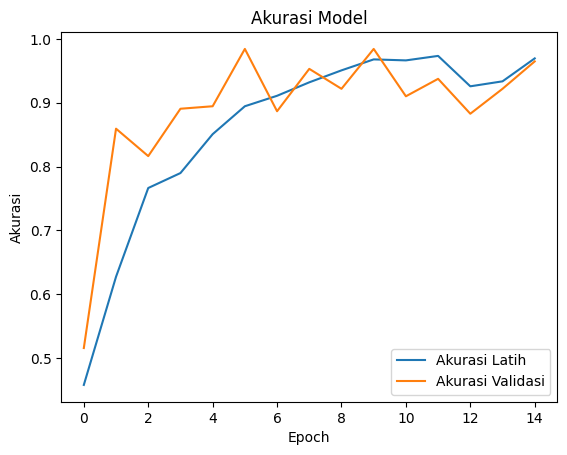

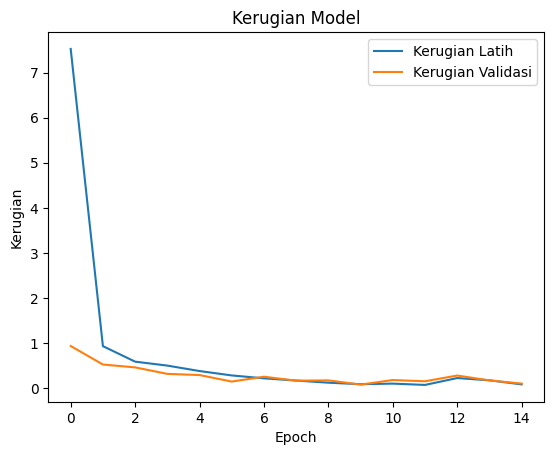

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Akurasi Latih')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Kerugian Latih')
plt.plot(history.history['val_loss'], label='Kerugian Validasi')
plt.title('Kerugian Model')
plt.ylabel('Kerugian')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# **Analisis Prediksi Menggunakan confusion matrix dan Laporan Klasifikasi**
 untuk mengevaluasi performa model dengan menghasilkan matriks kebingungan dan laporan klasifikasi. Matriks kebingungan menunjukkan jumlah prediksi yang benar dan salah untuk setiap kelas, sedangkan laporan klasifikasi memberikan metrik seperti precision, recall, dan f1-score untuk menilai akurasi model dalam mengklasifikasikan data validasi.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


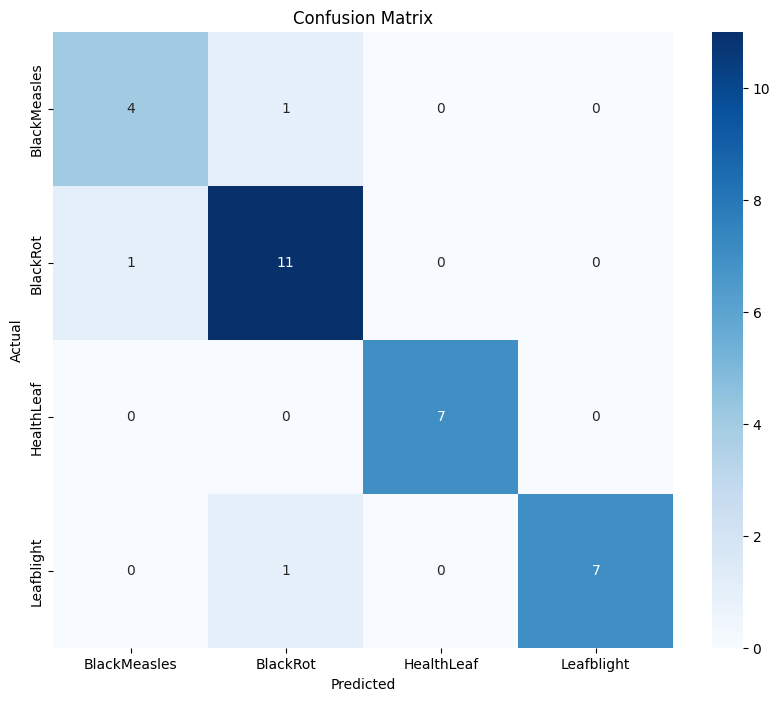

              precision    recall  f1-score   support

BlackMeasles       0.80      0.80      0.80         5
    BlackRot       0.85      0.92      0.88        12
  HealthLeaf       1.00      1.00      1.00         7
  Leafblight       1.00      0.88      0.93         8

    accuracy                           0.91        32
   macro avg       0.91      0.90      0.90        32
weighted avg       0.91      0.91      0.91        32



In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
class_names = ['BlackMeasles','BlackRot','HealthLeaf', 'Leafblight']

for val_images, val_labels in validation_dataset.take(1):
    predictions = model.predict(val_images)
    predicted_classes = np.argmax(predictions, axis=1)

    cm = confusion_matrix(np.argmax(val_labels, axis=1), predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(np.argmax(val_labels, axis=1), predicted_classes, target_names=class_names))


# **Prediksi Gambar**

Saving GrapeHealthy(10).jfif to GrapeHealthy(10) (2).jfif


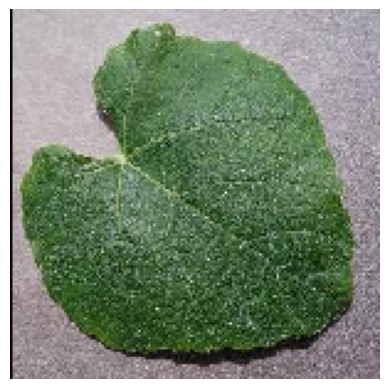

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediksi: HealthLeaf dengan probabilitas: 0.44
Gambar: GrapeHealthy(10) (2).jfif


In [27]:

from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

    path = fn
    img = image.load_img(path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    classes = model.predict(x)

    predicted_class = np.argmax(classes[0])

    print(f'Prediksi: {class_names[predicted_class]} dengan probabilitas: {classes[0][predicted_class]:.2f}')
    print(f'Gambar: {fn}')

